# Convenient data manipulation using Pandas

Although NumPy and SciPy provide useful functionality for manipulating numerical data, the semantic meaning of the data can be easily lost. Pandas provides a few versatile data structures and functionality to keep things together.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

## The DataFrame

In [2]:
df = pd.read_csv('http://ichart.finance.yahoo.com/table.csv?d=6&e=1&f=2009&g=d&a=7&b=19&c=2004&ignore=.csv&s=IBM')
type(df)

pandas.core.frame.DataFrame

In [4]:
df[:4]

,Date,Open,High,Low,Close,Volume,Adj Close
0,2009-07-01,105.000000,106.269997,104.730003,104.839996,5537300,90.502904
1,2009-06-30,105.690002,106.029999,103.809998,104.419998,7512600,90.140341
2,2009-06-29,105.989998,106.180000,105.160004,105.830002,4681800,91.357524
3,2009-06-26,106.500000,106.500000,105.050003,105.680000,5127900,91.228035


In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2009-07-01,105.000000,106.269997,104.730003,104.839996,5537300,90.502904
1,2009-06-30,105.690002,106.029999,103.809998,104.419998,7512600,90.140341
2,2009-06-29,105.989998,106.180000,105.160004,105.830002,4681800,91.357524
3,2009-06-26,106.500000,106.500000,105.050003,105.680000,5127900,91.228035
4,2009-06-25,103.699997,106.790001,103.510002,106.059998,6900600,91.556067


In [6]:
df = pd.read_csv(
    'http://ichart.finance.yahoo.com/table.csv?d=6&e=1&f=2009&g=d&a=7&b=19&c=2004&ignore=.csv&s=IBM',
    parse_dates='Date', index_col='Date')


In [7]:
df[:4]

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2009-07-01,105.000000,106.269997,104.730003,104.839996,5537300,90.502904
2009-06-30,105.690002,106.029999,103.809998,104.419998,7512600,90.140341
2009-06-29,105.989998,106.180000,105.160004,105.830002,4681800,91.357524
2009-06-26,106.500000,106.500000,105.050003,105.680000,5127900,91.228035


In [8]:
type(df['Open'])

pandas.core.series.Series

In [9]:
type(df)

pandas.core.frame.DataFrame

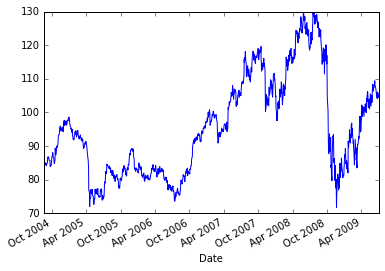

In [10]:
df['Close'].plot()

In [11]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2009-07-01,105.000000,106.269997,104.730003,104.839996,5537300,90.502904
2009-06-30,105.690002,106.029999,103.809998,104.419998,7512600,90.140341
2009-06-29,105.989998,106.180000,105.160004,105.830002,4681800,91.357524
2009-06-26,106.500000,106.500000,105.050003,105.680000,5127900,91.228035
2009-06-25,103.699997,106.790001,103.510002,106.059998,6900600,91.556067


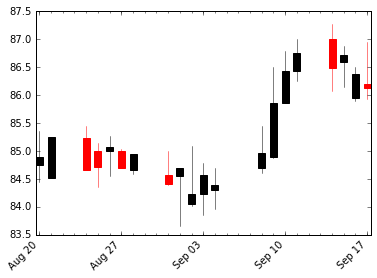

In [12]:
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
    
def candlestick_plot(df):
    df_lower_cols = df.copy()
    df_lower_cols.columns = [colname.lower() for colname in df_lower_cols.columns]
    to_plot = df_lower_cols[['open', 'high', 'low', 'close']]
    seconds_since_epoch = to_plot.index.astype(np.int64) // 1e9
    to_plot.insert(0, 'Date', 1 + seconds_since_epoch / (24 * 60 * 60))

    fig, ax = plt.subplots()

    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
    dayFormatter = DateFormatter('%d')      # e.g., 12

    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)

    candlestick_ohlc(ax, to_plot.values, width=0.6)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()
    
candlestick_plot(df[-20:])


But suppose you don't have open/high/low/close data. Maybe you just have a list of trades:

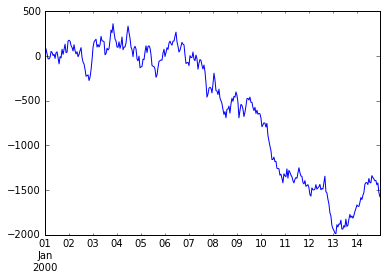

In [13]:
samples = 14 * 24 * 60 * 60      # per-second data
deltas = pd.Series(
    np.r_[100, np.random.randn(samples-1)], 
    index=pd.date_range('1/1/2000', periods=samples, freq='S'))
trades = deltas.cumsum()
trades[::3600].plot()

In [14]:
df2 = pd.DataFrame({'Trades': trades})
df2[:5]

,Trades
2000-01-01 00:00:00,100.000000
2000-01-01 00:00:01,99.521299
2000-01-01 00:00:02,98.622442
2000-01-01 00:00:03,99.580004
2000-01-01 00:00:04,99.284584


In [15]:
df3 = df2['Trades'].resample('D').ohlc()
df3.head()

,open,high,low,close
2000-01-01,100.000000,212.610569,-108.187426,176.317704
2000-01-02,176.889656,228.971398,-288.148477,98.646859
2000-01-03,97.821001,377.864660,-4.745025,101.510310
2000-01-04,101.389324,340.237513,-153.863134,-120.798761
2000-01-05,-122.611008,145.020489,-256.991789,-3.603175


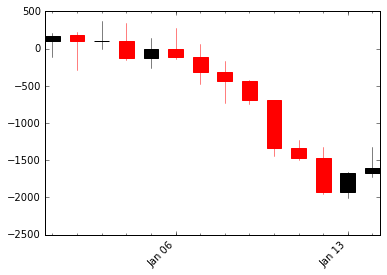

In [16]:
candlestick_plot(df3)

## Pivoting and hierarchical indexes

Pandas also provides the ability to look at rows and columns in a hierarchical way:

In [17]:
dates = pd.date_range('1/1/2000', periods=365, freq='W')
regions = np.array(list('NESW'))
stores_per_region = np.arange(4)
total_stores = dates.size * regions.size * stores_per_region.size
num_sales_per_store = np.random.poisson(4, total_stores)
vol_sales_per_store = np.random.normal(20, 2.0, total_stores) * num_sales_per_store

In [20]:
ind = pd.MultiIndex.from_product([dates, regions, stores_per_region], names=['date', 'region', 'store'])

In [21]:
df = pd.DataFrame({'Volume': vol_sales_per_store, 'Orders': num_sales_per_store}, index=ind)
df[:6]

Orders      Volume
date       region store                    
2000-01-02 N      0           4   87.768912
                  1           2   41.238936
                  2           5  105.195520
                  3           4   80.652166
           E      0           6  121.016801
                  1           1   18.703388

In [22]:
df2 = df.unstack(['region', 'store'])
df2[:6]

Orders                                                  ...      \
region          N                   E                   S          ...       
store           0    1    2    3    0    1    2    3    0    1     ...       
date                                                               ...       
2000-01-02    4.0  2.0  5.0  4.0  6.0  1.0  3.0  4.0  5.0  5.0     ...       
2000-01-09    4.0  4.0  5.0  3.0  4.0  4.0  4.0  5.0  3.0  6.0     ...       
2000-01-16    1.0  6.0  6.0  4.0  3.0  4.0  6.0  4.0  7.0  3.0     ...       
2000-01-23    4.0  1.0  6.0  2.0  7.0  4.0  6.0  2.0  1.0  8.0     ...       
2000-01-30    9.0  4.0  2.0  8.0  2.0  4.0  3.0  3.0  5.0  2.0     ...       
2000-02-06    5.0  0.0  1.0  2.0  6.0  3.0  5.0  5.0  1.0  2.0     ...       

                Volume                                                  \
region               E                       S                           
store                2           3           0           1           2   
date                                                                     
2000-01-02   39.507201   77.315081  107.557495  109.912264   55.345300   
2000-01-09   71.369364  104.231171   57.572160  122.956390   89.634939   
2000-01-16  131.523898   82.841584  125.680873   55.256393   38.043489   
2000-01-23  114.112074   40.575940   19.616010  141.758406  111.466330   
2000-01-30   65.883626   59.117936   99.802168   34.662137   78.148154   
2000-02-06  100.944103   95.202072   22.186300   40.301506  122.736789   

                                                                        
region                           W                                      
store                3           0           1           2           3  
date                                                                    
2000-01-02  108.379036   91.374831   69.196067  103.990321   43.006224  
2000-01-09  149.696833   80.802868  120.601734   38.406391  138.340525  
2000-01-16   67.636135   15.631156   54.636342   93.553699  171.985398  
2000-01-23   37.007188   66.440465  112.442190  234.920307  117.609239  
2000-01-30  105.372839  133.567807   41.398561  135.589202   86.524048  
2000-02-06   17.608936   83.298753   77.027362   63.293676  138.735323  

[6 rows x 32 columns]

In [23]:
df2['Orders', 'N', 3][:6]

date
2000-01-02    4.0
2000-01-09    3.0
2000-01-16    4.0
2000-01-23    2.0
2000-01-30    8.0
2000-02-06    2.0
Freq: W-SUN, Name: (Orders, N, 3), dtype: float64

In [24]:
df_flat = df.reset_index()
df_flat[:6]

,date,region,store,Orders,Volume
0,2000-01-02,N,0,4,87.768912
1,2000-01-02,N,1,2,41.238936
2,2000-01-02,N,2,5,105.195520
3,2000-01-02,N,3,4,80.652166
4,2000-01-02,E,0,6,121.016801
5,2000-01-02,E,1,1,18.703388


In [26]:
(df_flat['region'] == 'N')[:10]

0     True
1     True
2     True
3     True
4    False
5    False
6    False
7    False
8    False
9    False
Name: region, dtype: bool

In [28]:
df_flat[df_flat['region'] == 'N'].head()

,date,region,store,Orders,Volume
0,2000-01-02,N,0,4,87.768912
1,2000-01-02,N,1,2,41.238936
2,2000-01-02,N,2,5,105.195520
3,2000-01-02,N,3,4,80.652166
16,2000-01-09,N,0,4,88.456906


In [29]:
df_store_n_0 = df_flat[(df_flat['region']=='N') & (df_flat['store'] == 0)]
df_store_n_0[:6]

,date,region,store,Orders,Volume
0,2000-01-02,N,0,4,87.768912
16,2000-01-09,N,0,4,88.456906
32,2000-01-16,N,0,1,19.721603
48,2000-01-23,N,0,4,66.861079
64,2000-01-30,N,0,9,168.253887
80,2000-02-06,N,0,5,124.376055


In [30]:
df_store_n = df_flat[df_flat['region']=='N']
df_store_n[:6]

,date,region,store,Orders,Volume
0,2000-01-02,N,0,4,87.768912
1,2000-01-02,N,1,2,41.238936
2,2000-01-02,N,2,5,105.195520
3,2000-01-02,N,3,4,80.652166
16,2000-01-09,N,0,4,88.456906
17,2000-01-09,N,1,4,74.845419


### Pivot tables

We can create a pivot table if we can identify a unique index and column:

In [31]:
df_store_n_pivot = df_store_n.pivot(index='date', columns='store', values='Volume')
df_store_n_pivot[:6]

store,0,1,2,3
date,,,,
2000-01-02,87.768912,41.238936,105.195520,80.652166
2000-01-09,88.456906,74.845419,91.660599,59.355779
2000-01-16,19.721603,108.577556,109.218392,76.259948
2000-01-23,66.861079,20.420387,129.942499,37.041638
2000-01-30,168.253887,74.929954,41.007438,122.339851
2000-02-06,124.376055,0.000000,18.872171,35.755030


## File I/O

Pandas has the ability to read and write csv files, of course, as well as many other data formats. Each format is accessed via the `read_{format}` functions and the `DataFrame.to_{format}` methods:

 - csv
 - excel
 - hdf
 - sql
 - json
 - msgpack (experimental)
 - html
 - gbq (experimental)
 - stata
 - sas
 - clipboard
 - pickle

In [32]:
df.to_csv('store_data.csv')

In [33]:
lines = open('store_data.csv').readlines()[:6]
print ''.join(lines)

date,region,store,Orders,Volume
2000-01-02,N,0,4,87.7689115461
2000-01-02,N,1,2,41.2389357947
2000-01-02,N,2,5,105.195519741
2000-01-02,N,3,4,80.6521658551
2000-01-02,E,0,6,121.016800563



In [34]:
df_csv = pd.read_csv('store_data.csv')

In [35]:
df_csv[:6]

,date,region,store,Orders,Volume
0,2000-01-02,N,0,4,87.768912
1,2000-01-02,N,1,2,41.238936
2,2000-01-02,N,2,5,105.195520
3,2000-01-02,N,3,4,80.652166
4,2000-01-02,E,0,6,121.016801
5,2000-01-02,E,1,1,18.703388


In [36]:
df_csv.index = ind
df_csv[:6]

date region  store  Orders      Volume
date       region store                                              
2000-01-02 N      0      2000-01-02      N      0       4   87.768912
                  1      2000-01-02      N      1       2   41.238936
                  2      2000-01-02      N      2       5  105.195520
                  3      2000-01-02      N      3       4   80.652166
           E      0      2000-01-02      E      0       6  121.016801
                  1      2000-01-02      E      1       1   18.703388

We can also use pandas to scrape data from the web:

In [39]:
tables = pd.read_html(
    'http://finance.yahoo.com/q/hp?s=IBM+Historical+Prices', 
    'Volume', 
    flavor='bs4',
    header=0)


In [44]:
tables[2].head()

,Date,Open,High,Low,Close,Volume,Adj Close*
0,"Apr 26, 2016",148.65,149.79,147.90,149.08,2974800.0,149.08
1,"Apr 25, 2016",148.16,148.90,147.11,148.81,2848900.0,148.81
2,"Apr 22, 2016",149.44,151.00,147.50,148.50,5191900.0,148.50
3,"Apr 21, 2016",146.58,150.12,146.46,149.30,6017700.0,149.30
4,"Apr 20, 2016",144.24,147.20,144.00,146.11,6754300.0,146.11


In [48]:
tables[2].iloc[-1]

Date          * Close price adjusted for dividends and splits.
Open                                                       NaN
High                                                       NaN
Low                                                        NaN
Close                                                      NaN
Volume                                                     NaN
Adj Close*                                                 NaN
Name: 67, dtype: object

In [49]:
df_ibm = tables[2][:-1]    # strip off a footnote
df_ibm.head()

,Date,Open,High,Low,Close,Volume,Adj Close*
0,"Apr 26, 2016",148.65,149.79,147.90,149.08,2974800.0,149.08
1,"Apr 25, 2016",148.16,148.90,147.11,148.81,2848900.0,148.81
2,"Apr 22, 2016",149.44,151.00,147.50,148.50,5191900.0,148.50
3,"Apr 21, 2016",146.58,150.12,146.46,149.30,6017700.0,149.30
4,"Apr 20, 2016",144.24,147.20,144.00,146.11,6754300.0,146.11


In [50]:
df_ibm.index = pd.to_datetime(df_ibm['Date'], format='%b %d, %Y')

In [51]:
df_ibm[:6]

,Date,Open,High,Low,Close,Volume,Adj Close*
Date,,,,,,,
2016-04-26,"Apr 26, 2016",148.65,149.79,147.90,149.08,2974800.0,149.08
2016-04-25,"Apr 25, 2016",148.16,148.90,147.11,148.81,2848900.0,148.81
2016-04-22,"Apr 22, 2016",149.44,151.00,147.50,148.50,5191900.0,148.50
2016-04-21,"Apr 21, 2016",146.58,150.12,146.46,149.30,6017700.0,149.30
2016-04-20,"Apr 20, 2016",144.24,147.20,144.00,146.11,6754300.0,146.11
2016-04-19,"Apr 19, 2016",146.47,146.95,142.61,144.00,13190200.0,144.00


In [53]:
df_ibm.resample('w').head()

/Users/rick446/.virtualenvs/intermediate-python/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


,High,Low,Close,Volume,Adj Close*
Date,,,,,
2016-01-24,124.7400,121.770,122.5000,9238400.0,121.2600
2016-01-31,123.7660,121.700,122.5280,5456160.0,121.2900
2016-02-07,126.4040,123.898,125.7420,5105980.0,124.4720
2016-02-14,124.0880,120.598,122.0260,6406880.0,122.0260
2016-02-21,129.3275,126.295,128.5925,5989825.0,128.5925


In [54]:
df_ibm.describe()

,High,Low,Close,Volume,Adj Close*
count,66.000000,66.000000,66.000000,6.600000e+01,66.000000
mean,139.540606,136.955152,138.472576,5.035314e+06,138.263788
std,10.843938,11.032611,10.993318,2.013714e+06,11.278235
min,119.660000,116.900000,117.850000,2.848900e+06,117.850000
25%,128.535000,125.212500,127.880000,3.738325e+06,127.052500
50%,141.820000,138.660000,140.300000,4.414200e+06,140.300000
75%,149.720000,147.500000,148.597500,5.545825e+06,148.597500
max,153.520000,151.910000,152.530000,1.319020e+07,152.530000


In [55]:
from datetime import datetime
from pandas_datareader import data, wb
start = datetime(2010, 1, 1)
end = datetime(2010, 1, 27)

In [56]:
df_ibm = data.DataReader("IBM", 'yahoo', start, end)
df_ibm.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,131.179993,132.970001,130.850006,132.449997,6155300,115.385996
2010-01-05,131.679993,131.850006,130.100006,130.850006,6841400,113.992138
2010-01-06,130.679993,131.490005,129.809998,130.000000,5605300,113.251641
2010-01-07,129.869995,130.250000,128.910004,129.550003,5840600,112.859619
2010-01-08,129.070007,130.919998,129.050003,130.850006,4197200,113.992138


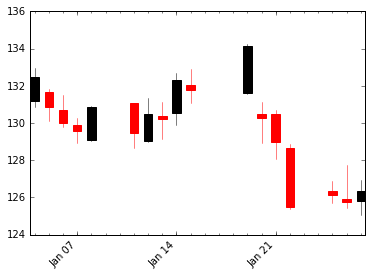

In [57]:
candlestick_plot(df_ibm)

In [59]:
dir(wb)

['PANDAS_0170',
 'WorldBankReader',
 '_BaseReader',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '_cached_series',
 'country_codes',
 'download',
 'get_countries',
 'get_indicators',
 'lrange',
 'np',
 'pd',
 'reduce',
 'search',
 'string_types',
 'warnings']

In [62]:
df_ibm.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,131.179993,132.970001,130.850006,132.449997,6155300,115.385996
2010-01-05,131.679993,131.850006,130.100006,130.850006,6841400,113.992138
2010-01-06,130.679993,131.490005,129.809998,130.000000,5605300,113.251641
2010-01-07,129.869995,130.250000,128.910004,129.550003,5840600,112.859619
2010-01-08,129.070007,130.919998,129.050003,130.850006,4197200,113.992138


In [75]:
df_ibm.loc[datetime(2010,1,5)]

Open         1.316800e+02
High         1.318500e+02
Low          1.301000e+02
Close        1.308500e+02
Volume       6.841400e+06
Adj Close    1.139921e+02
Name: 2010-01-05 00:00:00, dtype: float64

In [76]:
df_ibm.loc[datetime(2010,1,5), 'Low']

130.10000600000001

In [77]:
df_ibm.iloc[:2, :2]

,Open,High
Date,,
2010-01-04,131.179993,132.970001
2010-01-05,131.679993,131.850006


In [78]:
df_ibm.ix[:2, ['High', 'Low']]

,High,Low
Date,,
2010-01-04,132.970001,130.850006
2010-01-05,131.850006,130.100006


In [80]:
del df_ibm['Volume']

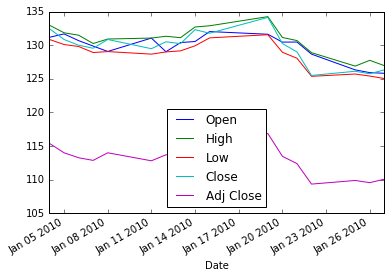

In [81]:
df_ibm.plot()

### Exercises:
`df = pd.read_csv('http://ichart.finance.yahoo.com/table.csv?d=6&e=1&f=2009&g=d&a=7&b=19&c=2004&ignore=.csv&s=IBM')`

Using the previous IBM dataframe, complete the following:
- Using numpy, determine the average price on June 30, 2009. (For our purposes here, 'average' will just be the mean of min and max)
- Using numpy, determine the min, max, and median closing price for the dataset.
- Limit the dataframe with Pandas to find the min, max, and median closing price for only 2005.

In [91]:
df = pd.read_csv('http://ichart.finance.yahoo.com/table.csv?d=6&e=1&f=2009&g=d&a=7&b=19&c=2004&ignore=.csv&s=IBM')
df.index = df.Date

In [92]:
df[df.index.str.startswith('2005-')].describe()

,Open,High,Low,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,83.814286,84.452302,83.265476,83.786191,6.107654e+06,68.120109
std,6.532709,6.480783,6.575411,6.501398,2.731251e+06,5.203407
min,72.529999,73.690002,71.849998,72.010002,2.199300e+06,58.382045
25%,78.247498,79.519997,77.467501,78.577497,4.457125e+06,64.029466
50%,82.840000,83.619999,82.474998,83.020001,5.460550e+06,67.693782
75%,89.467499,90.025001,89.132497,89.334999,7.009550e+06,72.779940
max,98.970001,99.099998,97.250000,97.750000,2.790630e+07,79.099823
